In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
data=pd.read_csv("C:/Users/HP/TSLA.csv")

In [3]:
data.head()

Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900

In [4]:
def check_df(dataframe,head=5):
    print("#################### Shape #################### ")
    print(dataframe.shape)
    print("#################### Types #################### ")
    print(dataframe.dtypes)
    print("#################### Head #################### ")
    print(dataframe.head(head))
    print("#################### Tail #################### ")
    print(dataframe.dtypes)
    print("#################### NA #################### ")
    print(dataframe.isnull().sum())
    print("#################### Quantiles #################### ")
    print(dataframe.quantile([0,0.5,0.50,0.95,0.99,1]).T)

In [5]:
check_df(data)

#################### Shape #################### 
(2416, 7)
#################### Types #################### 
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
#################### Head #################### 
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
#################### Tail #################### 
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
#################### NA 

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [6]:
data["Date"]=pd.to_datetime(data["Date"])

In [7]:
data.head()

Date       Open   High        Low      Close  Adj Close    Volume
0 2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1 2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2 2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3 2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4 2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900

In [8]:
#preparing the data
tesla_data=data[["Date","Close"]]

In [9]:
tesla_data.head()

Date      Close
0 2010-06-29  23.889999
1 2010-06-30  23.830000
2 2010-07-01  21.959999
3 2010-07-02  19.200001
4 2010-07-06  16.110001

In [10]:
print("Min. Tarih:",tesla_data["Date"].min())
print("Max. Tarih:",tesla_data["Date"].max())

Min. Tarih: 2010-06-29 00:00:00
Max. Tarih: 2020-02-03 00:00:00


In [11]:
tesla_data.index=tesla_data["Date"]

In [12]:
tesla_data

Date       Close
Date                             
2010-06-29 2010-06-29   23.889999
2010-06-30 2010-06-30   23.830000
2010-07-01 2010-07-01   21.959999
2010-07-02 2010-07-02   19.200001
2010-07-06 2010-07-06   16.110001
...               ...         ...
2020-01-28 2020-01-28  566.900024
2020-01-29 2020-01-29  580.989990
2020-01-30 2020-01-30  640.809998
2020-01-31 2020-01-31  650.570007
2020-02-03 2020-02-03  780.000000

[2416 rows x 2 columns]

In [13]:
tesla_data.drop("Date",axis=1,inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_25068\3872239942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_data.drop("Date",axis=1,inplace=True)


In [14]:
tesla_data

Close
Date                  
2010-06-29   23.889999
2010-06-30   23.830000
2010-07-01   21.959999
2010-07-02   19.200001
2010-07-06   16.110001
...                ...
2020-01-28  566.900024
2020-01-29  580.989990
2020-01-30  640.809998
2020-01-31  650.570007
2020-02-03  780.000000

[2416 rows x 1 columns]

In [15]:
result_data=tesla_data.copy()

In [18]:
plt.figure(figsize=(6,3))
plt.plot(tesla_data["Close"],color="blue");
plt.ylabel("Price")
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.show()

In [19]:
tesla_data=tesla_data.values

In [20]:
tesla_data[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [21]:
tesla_data=tesla_data.astype("float32")

In [22]:
def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos

In [23]:
train,test,pos=split_data(tesla_data,0.20)

In [24]:
print(train.shape,test.shape)

(1933, 1) (483, 1)


In [25]:
scaler_train=MinMaxScaler(feature_range=(0,1))

In [26]:
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [27]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)

In [28]:
lookback=20

In [29]:
X_train,y_train=create_features(train,lookback)

In [30]:
X_test,y_test=create_features(test,lookback)

In [31]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [32]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [33]:
y_test[0:5]

array([0.14734703, 0.1796416 , 0.21088794, 0.20020628, 0.18416718],
      dtype=float32)

In [34]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))

In [35]:
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [36]:
y_train=y_train.reshape(-1,1)

In [37]:
y_test=y_test.reshape(-1,1)

In [38]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [39]:
#Modeling
model=Sequential()
model.add(LSTM(units=50,
              activation="relu",
              input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
model.compile(loss="mean_squared_error",optimizer="adam")

In [46]:
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]

In [48]:
history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=20, validation_data=(X_test,y_test), callbacks=callbacks, shuffle=False)

Epoch 1/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0028  
Epoch 1: val_loss did not improve from 0.00134
96/96 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 2/100
77/96 [=======================>......] - ETA: 0s - loss: 0.0021    
Epoch 2: val_loss did not improve from 0.00134
96/96 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 3/100
75/96 [======================>.......] - ETA: 0s - loss: 0.0021   
Epoch 3: val_loss improved from 0.00134 to 0.00101, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 4/100
74/96 [======================>.......] - ETA: 0s - loss: 0.0019    
Epoch 4: val_loss did not improve from 0.00101
96/96 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 5/100
86/96 [=========================>....] - ETA: 0s - loss: 0.0025   
Epoch 5: val_loss did not improve fr

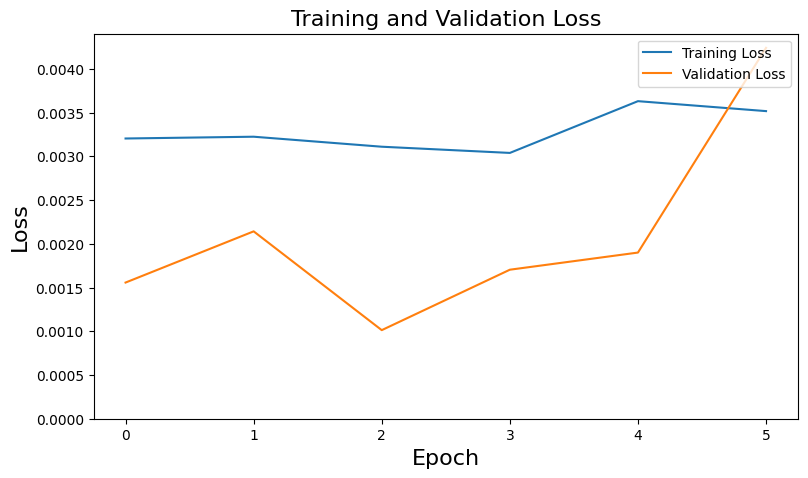

In [49]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

In [50]:
#Evaluation
loss=model.evaluate(X_test,y_test,batch_size=20)

24/24 [==============================] - 0s 2ms/step - loss: 0.0042


In [51]:
print("\nTest loss:%.1f%%"%(100.0*loss))


Test loss:0.4%


In [52]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

15/15 [==============================] - 0s 1ms/step


In [53]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:17.770992279052734
Test RMSE:39.13945388793945


In [58]:
train_prediction_data=result_data[lookback:pos]
#train_prediction_data["Predicted"]=train_predict
train_prediction_data_copy = train_prediction_data.copy()
train_prediction_data_copy["Predicted"] = train_predict
train_prediction_data.head()

Close
Date                 
2010-07-28  20.719999
2010-07-29  20.350000
2010-07-30  19.940001
2010-08-02  20.920000
2010-08-03  21.950001

In [71]:
test_prediction_data=result_data[pos+lookback:]
test_prediction_data["Predicted"]=test_predict
test_prediction_data.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_25068\3631762894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prediction_data["Predicted"]=test_predict


Close   Predicted
Date                              
2018-04-03  267.529999  319.221344
2018-04-04  286.940002  314.756683
2018-04-05  305.720001  316.486145
2018-04-06  299.299988  324.034637
2018-04-09  289.660004  326.139709

In [72]:
plt.figure(figsize=(14,5))
plt.plot(result_data,label="Real Values")
plt.plot(train_prediction_data_copy["Predicted"],color="brown",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()